# Approximating electromagnetic shielding using machine learning

The goal of this notebook is to apply standard machine learning techniques to our dataset. We know that the lab already obtained a RMSE of $0.6$ using kernel ridge regression. We seek to validate this result in first place and then we eventually expect to improve it. In order to do so, we try various loss functions and regulizers.

It is also important to note that we are working here on a reduced dataset. Recall that our initial dataset was pretty large and that we found different ways to reduce the feature space without influencing too much the quality of our predictions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from src.regressions import *
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
DATA_FOLDER = "data/"
X = np.load(DATA_FOLDER + "ML/x_train.npy")
y = np.load(DATA_FOLDER + "ML/y.npy")

np.random.seed(1)

In [4]:
print("X: " + str(X.shape))
print("y: " + str(y.shape))

X: (30349, 4500)
y: (30349,)


## Idea 1: Good ol' least squares (MSE loss without regularizer)

We first try a standard and naive implementation of `least_squares` on the full dataset. This will give us a first raw result:

In [5]:
def run_least_squares():
    w_star = least_squares(y, X)
    loss = rmse(y, X, w_star)
    print("Loss = " + str(loss))

run_least_squares()

Loss = 26.16344670274864


We see that the loss is quite large! We hope to do better by using polynomial expansion and 4-fold cross-validation to find the best `degree`:

In [6]:
k_fold = 4
k_indices = build_k_indices(y, k_fold)

def run_least_squares_poly():
    rmse_tr = []
    rmse_te = []

    for degree in range(4):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            try:
                loss_tr, loss_te, _ = cross_validation(y, X, k_indices, k, degree, least_squares)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
            except:
                print("Could not inverse the matrix")
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))
    pd.DataFrame([rmse_tr, rmse_te]).add_prefix("Degree ").rename({0: "Train error", 1: "Test error"}).head()
    return rmse_tr, rmse_te

In [7]:
run_least_squares_poly()

([3.213171631581826,
  0.40145325242460417,
  0.2659636431823623,
  0.1652126444248406],
 [3.2132414414047386,
  0.5357537373798815,
  0.6076663576371552,
  0.853874297553556])

The result above is composed of two arrays. The first one contains at index $i$ the __train error__ for polynomial expansion of degree $i$. Train error does not bring much useful information, hence we rather inspect the second array, representing the __test error__. It is constructed in an identical way.

We see that polynomial expansion provides better results. In particular, the best `degree` is 1.

__By adding a single feature of constant values, we manage to decrease the RMSE from 26 to 0.7!__

## Idea 2: Ridge regression (MSE loss with $\mathcal{L}_2$-regularizer)

Since least squares optimize `MSE` as loss function, we decide to tackle the question of overitting immediately and consider adding to least squares a regularizer for the complexity of the model to be part of the optimization as well.

In [8]:
k_fold = 4
k_indices = build_k_indices(y, k_fold)

def run_ridge_regression():
    for lambda_ in np.logspace(-5, 1, 7):
        print("Lambda = " + str(lambda_))
        for degree in range(1, 3):
            print("    Degree = " + str(degree))
            rmse_tr_tmp = []
            rmse_te_tmp = []
            for k in range(k_fold):
                ridge_lambda = lambda y, X: ridge_regression(y, X, lambda_)
                loss_tr, loss_te, _ = cross_validation(y, X, k_indices, k, degree, ridge_lambda)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
            print("        " + str(np.mean(rmse_tr_tmp)))
            print("        " + str(np.mean(rmse_te_tmp)))

In [9]:
run_ridge_regression()

Lambda = 1e-05
    Degree = 1
        0.40145325242460456
        0.5357537372320587
    Degree = 2
        0.26596380103399736
        0.607666163440107
Lambda = 0.0001
    Degree = 1
        0.4014532524246221
        0.5357537359016747
    Degree = 2
        0.2659683198847004
        0.6076760153324785
Lambda = 0.001
    Degree = 1
        0.4014532524263871
        0.535753722599882
    Degree = 2
        0.26597880149891057
        0.6077023419396217
Lambda = 0.01
    Degree = 1
        0.40145325260288683
        0.5357535897864518
    Degree = 2
        0.26598240518404337
        0.60770831648428
Lambda = 0.1
    Degree = 1
        0.40145327025267574
        0.535752282101457
    Degree = 2
        0.26605512986311564
        0.6078706202481085
Lambda = 1.0
    Degree = 1
        0.40145503506146574
        0.5357412499056584
    Degree = 2
        0.26837515562810677
        0.6137603953993617
Lambda = 10.0
    Degree = 1
        0.4016313108003009
        0.535835073442734


We see that all results are quite close to each other but if we pay attention to the details, we see that the best test error is achieved with a regulizer of $\lambda = 1$ for `degree 1` and $\lambda = 10^{-4}$ for `degree 2`. In all cases, `degree 1` remains our best degree value and we already reach __RMSE of 0.53__!

Since the results are almost equal with and without a regulizer and provided that the test error increases for larger values of $\lambda$, we deduce that the model is not overfitted and that a $\mathcal{L}_2$ regulizer is useless...

## Idea 3: Lasso (MSE loss with $\mathcal{L}_1$-regularizer)

In the section above, we saw that $\mathcal{L}_2$-regularization did not prove useful. For completeness, we try $\mathcal{L}_1$-regularization as well. Since there exists no analytical solution to the minimum of the `lasso` loss, we decide to use `mini-batch-SGD`.

In [10]:
def run_lasso():
    for lambda_ in np.concatenate([[0], np.logspace(-5, 2, 8)]):
        print("lambda = " + str(lambda_))
        for degree in range(1, 3):
            print("    degree = " + str(degree))
            rmse_tr_tmp = []
            rmse_te_tmp = []
    
            for k in range(k_fold):
                lasso_lambda = lambda y, X, w: lasso(y, X, w, lambda_)
                lasso_stoch_grad_lambda = lambda y, X, w: lasso_stoch_grad(y, X, w, lambda_)
                loss_lambda = lambda y, X: stochastic_gradient_descent(y, X, np.zeros(X.shape[1]), 100, 1e-1, lasso_lambda, lasso_stoch_grad_lambda, batch_size = 100)
                loss_tr, loss_te, _ = cross_validation(y, X, k_indices, k, degree, loss_lambda)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
            print("        " + str(np.mean(rmse_tr_tmp)))
            print("        " + str(np.mean(rmse_te_tmp)))

Before we run it, we try a `stochastic_gradient_descent` using a `lasso`, just to see what we can expect:

In [41]:
lambda_ = 0
lasso_lambda = lambda y, X, w: lasso(y, X, w, lambda_)
lasso_stoch_grad_lambda = lambda y, X, w: lasso_stoch_grad(y, X, w, lambda_)
_, losses = stochastic_gradient_descent(y, X, np.zeros(X.shape[1]), 80, 1e-1, lasso_lambda, lasso_stoch_grad_lambda, batch_size = 100, detail = True)

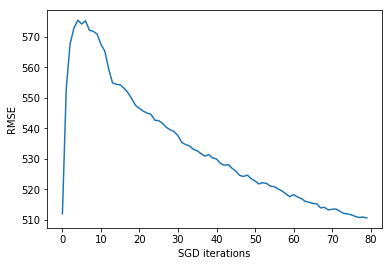

In [42]:
plt.xlabel("SGD iterations")
plt.ylabel("RMSE")
plt.plot(losses)

In [43]:
print(np.argmin(losses))
print(losses[np.argmin(losses)])

79
510.5618316456103


Looking at the result, we see that convergence is really slow. Indeed, since $\lambda = 0$, we are basically optimizing a standard `MSE` for which we know (from above) that the optimal solution is 26. We deduce it is unlikely to do better than `ridge_regression`, and we drop this idea.

## Idea 4: MAE loss (with SGD) with $\mathcal{L}_2$-regularizer 

In the lectures, we also talked about `MAE` loss, which we decide to try here. From the lab, we know that `MSE` is well-suited for out task, but we decide to implement `MAE` as well and hope to be surprised!

Again, the minimum of `MAE` can not be found using any kind of closed-form formula, and we naturally decide to use `mini-batch-SGD` one more time.

In [25]:
def run_mae_sgd():
    for lambda_ in [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
        print("lambda = " + str(lambda_))
        for degree in range(1, 3):
            print("    degree = " + str(degree))
            rmse_tr_tmp = []
            rmse_te_tmp = []
            
            lambda_mae = lambda y, X, w: mae(y, X, w, lambda_)
            lambda_mae_stoch_grad = lambda y, X, w: mae_stoch_grad(y, X, w, lambda_)
            for k in range(k_fold):
                mae_lambda = lambda y, X: stochastic_gradient_descent(y, X, np.zeros(X.shape[1]), 50, 1, lambda_mae, lambda_mae_stoch_grad, batch_size = 100)
                loss_tr, loss_te, _ = cross_validation(y, X, k_indices, k, degree, mae_lambda)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
            print("        " + str(np.mean(rmse_tr_tmp)))
            print("        " + str(np.mean(rmse_te_tmp)))

Again, we first try to validate the method before we run that.

Degree 1
    loss = 26.159135164285743
Degree 2
    loss = 23.871869495951007


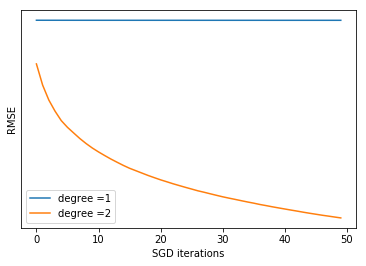

In [26]:
for i in [1, 2]:
    lambda_ = 0
    print("Degree " + str(i))
    X_ = build_poly(X, i)
    lambda_mae = lambda y, X, w: mae(y, X, w, lambda_)
    lambda_grad_mae = lambda y, X, w: mae_stoch_grad(y, X, w, lambda_)
    ws, losses = stochastic_gradient_descent(y, X_, np.zeros(X_.shape[1]), 50, 1, lambda_mae, lambda_grad_mae, batch_size = 100, detail = True)
    plt.xlabel("SGD iterations")
    plt.ylabel("RMSE")
    plt.semilogy(losses, label = "degree =" + str(i))
    plt.legend()
    print("    loss = " + str(losses[np.argmin(losses)]))

The loss obtained reaches RMSE of approx. 23 for degree 2 polynomial expansion. We think that we probably won't be able to do better than ridge regression, but the effort is worth trying. Degree 3 has been tested separately and gives RMSE > 1000, hence we exclude it from the possible degree candidates.

In [27]:
run_mae_sgd()

lambda = 0
    degree = 1
        26.355582665289
        26.355784279496454
    degree = 2
        24.162021525775195
        24.162715017406338
lambda = 1e-06
    degree = 1
        26.35558775976868
        26.355774697392782
    degree = 2
        24.170212141069207
        24.170990366946498
lambda = 1e-05
    degree = 1
        26.355588727236167
        26.355778198307007
    degree = 2
        24.177040652403203
        24.178066413218787
lambda = 0.0001
    degree = 1
        26.355585558178895
        26.35578251376678
    degree = 2
        24.157708463881253
        24.15916725428593
lambda = 0.001
    degree = 1
        26.35558779628549
        26.355787983716368
    degree = 2
        24.175575073034818
        24.176407819894198
lambda = 0.01
    degree = 1
        26.355634820756176
        26.355788383863935
    degree = 2
        24.231269643413476
        24.231798904947226


As expected, we see that the results are not as good as ridge regression...

# Conclusion
We managed to get a lower error than the lab using `Ridge Regression` with polynomial expansion, which we are really proud of. Moreover, we have tried other standard losses and regularizers that did not work as good and we conclude that we probably won't be able to do a lot better using classical machine learning approaches. In parallel, we run a few deep learning experiments that lead to promising results and therefore we decide to stop here our research on the machine learning aspects of the project.